#### Implementing FNN from Scratch for a Regression task on sklearn dataset.
        No of Hidden layers = 4
        No of Hidden Units = 20
        No of features = 5
        No of epochs = 1000
        Mini-batch size = 32 (if using mini batch S-Gradient descent)
        Learning Algorithm = Gradient descent with backpropagation (Initial try)
        Loss function = sum of squares fxn (Output Activation = Linear) ---> Regression
        Loss function = cross-entropy (Output Actiavation = softmax) ----> Classification
        Using Sigmoid(logistic function) for activation in between layers for classification
        Using Relu for activation in between layers for regression

Imports 

In [19]:
import tensorflow as tf
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Dataset

In [20]:
X, y = make_regression(n_samples=1000, n_features=5, noise=0.1) # Adding a small amount ot gaussian noise to make the data more realistic
y = y.reshape(-1, 1)  # Reshape y to be a column vector for tensorflow compatibility
"""X = 2D array of shape(1000,5) containing the input features 
y = 2D array of shape(1000,1) containing the target values"""
# """Alternate way"""
# from sklearn.datasets import fetch_california_housing
# data = fetch_california_housing()
# X = data.data[:, :5]  # Select first 5 features for simpicity(no GPU)
# y = data.target.reshape(-1, 1)

'X = 2D array of shape(1000,5) containing the input features \ny = 2D array of shape(1000,1) containing the target values'

Split the Data

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 30 for test 70 for train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15 for val 15 for test
"""random state = 42 implies that the data is shuffled in the same way every time the code is run"""

'random state = 42 implies that the data is shuffled in the same way every time the code is run'

In [22]:
X_train.shape, X_val.shape, X_test.shape

((700, 5), (150, 5), (150, 5))

Standardizing the features(common step)

In [23]:
# Normalize target values
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train) # scakes the data to have zero mean and unit variance 
y_val = y_scaler.transform(y_val) # scales the validation target values using the mean and standard deviation computed from the training data
y_test = y_scaler.transform(y_test)

Defining the Model 
4 hidden layers, each 20 nodes, activation fxn = Relu(for Regression),Sigmoid(for Classification), Output layer activation fxn = linear, error fxn = MSE 

In [24]:
# Updated model with initializer
"""Advantage of using GlorotUniform initializer is that it helps in maintain the variance of the weights"""
class FeedForwardNN(tf.keras.Model):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform()) # this initalizer for initializing the weights
        self.hidden2 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.hidden3 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.hidden4 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.output_layer = tf.keras.layers.Dense(1, activation=None) # inear activation function for regression"""
    # takes inputs and passes them through the each hidden layer sequntially
    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output_layer(x)

From hereon instead of using the standard tf library opt's, writing the own types of Opt for better understanding along with thier drawbacks and why we need improvement

In [25]:
import numpy as np
import tensorflow as tf

class Optimizers:
    def __init__(self, method='vanilla', learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-7, decay_rate=0.9,batch_size=None):
        self.method = method
        self.learning_rate = learning_rate
        self.beta1 = beta1  # Momentum parameter for momentum-based optimizers
        self.beta2 = beta2  # RMSProp/Adam parameter
        self.epsilon = epsilon
        self.decay_rate = decay_rate  # For exponential decay in RMSProp
        self.momentum = None
        self.velocity = None
        self.squared_gradients = None
        self.batch_size = batch_size # For mini-batch optimization
        self.t = 0  # Time step for Adam
    """Parameter Updation rules : 
        Vanilla GD: w_t+1 = w_t - learning_rate * gradient wrt w, where w_t is the weight at time t[similarly for bias]
        Gradient wrt w = dl(w,b)/dw, where l is the loss function and w,b are weights and biases respectively
        Disadaavantages of Vanilla Gradient Descent:
        1)It makes very small movements even in the area with more loss --> gentle(gradient is small) region so even after many steps we may not be able to converge
        2)In areas where curve is gentle updates are small , where as where curve is steep updates are large
        3)If we hit a gentle region slow progress
        Mini-Batch Gradient Descent: w_t+1 = w_t - learning_rate * (1/batch_size) * sum(gradient wrt w), where w_t is the weight at time t[similarly for bias]
        Advantages:
        1)Just a bit faster thats it,bcz we are making a movement after a batch of samples
        Disadvantages:
        Same as above
        Momentum based GD: Moving repeatedly in the same drxn --> take bigger steps and move faster
        Update Rule : u_t = beta*u_t-1 + gradient,u_-1 = 0; w_t+1 = w_t - learning_rate * u_t , 0 <= beta < 1 (storing history of updates)
        Disadvantages:
        1)Momentum may carry it out,like it cant stop when auctually required to---many oscillations
        Nestrov Accelerated Gradient: NAG--> Look ahead before making a step
        Update Rule : u_t = beta*u_t-1 + gradient(w_t-beta*u_t-1),u_-1 = 0; w_t+1 = w_t - learning_rate * u_t , 0 <= beta < 1 (storing history of updates)
        Advantages:
        1) Looking ahead makes less oscillations and thus chances of escaping a minima valley is more
        Disadvantages:
        1) Still may oscillate
        SGD : in GD we are going over the entire data before updating once, but in SGD we are updating parameters for every single point(useful if n is too large)
        Disadvantages:
        1) Its approximate not exact
        2) Many oscillations because we make greedy decisions--> a parameter update which is locally good may disappoint other points in the future
        Instead of estimating one point at a time, we can do in batches ---> Mini-Batch Gradient Descent
        NAG and Mom are still much faster than SGD
        -----Learning rate Improvemnt -----
        Methods : 
        Step dacay: Half the learning rate after an epoch if the validation error is more than that of the previous epoch
        Exponential decay: learning_rate = eta_0 ^ kt where eta_0 and k are hyperparameters,t is a step parameter
        1/t decay : n = n_0/1+kt
        AdaGrad: Adaptive learning rate,learning rate is different for each parameter---more updates == more decay
        rule : v_t= v_t+1 + (gradient)**2 and w_t+1 = w_t - (learning_rate/sqrt(v_t+epsilon)) * gradient
        if a feature is sparse/rare we are just wasting a lot of time computing it because the gradient term is 0 for most of the values
        Assuming w is sparse:
        All 3 algo : Momentum,SGD,Nestrov moves first in the drxn of dense b and if no updates are not possible anymore then it moves in the drxn of sparse w
        but this is not ideal behaviour
        Adagrad slows down near minimum because of deacaying LR
        Disadvantages:
        over time the effective learning rate for b will decay to an extent that there will be no further updates to b
        As a result, after a while, the frequent parameters will start receiving very small updates because of the decayed learning rate
        To avoid this why not decay the denominator and prevent its rapid growth
        RMSProp: Lr may inc or dec or remain constant ---> means oscillations can be stuck in a loop forver , fix == chosing n_0 appropiately 
        ---NOT COMPLETED--
        """
    def apply_gradients(self, weights, gradients):
        if self.method == 'vanilla':
            # Vanilla Gradient Descent
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g)
        elif self.method == 'mini_batch': ## **** Doubt
        # Mini-Batch Gradient Descent: Subset of dataset
            if self.batch_size is None:
                raise ValueError("Batch size must be specified for mini-batch optimization.")
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g / self.batch_size)  # Averaging gradients for the mini-batch
        
        elif self.method == 'sgd': # wrong code 
            # Stochastic Gradient Descent: Single sample
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g)

        elif self.method == 'momentum':
            # Momentum
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                w.assign_sub(self.learning_rate * self.momentum[i])

        elif self.method == 'nesterov':
            # Nesterov Accelerated Gradient (NAG)
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                prev_momentum = self.momentum[i]
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                w.assign_sub(self.learning_rate * (self.beta1 * prev_momentum + (1 - self.beta1) * g))

        elif self.method == 'adagrad':
            # Adagrad
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] += tf.square(g)
                adjusted_lr = self.learning_rate / (tf.sqrt(self.squared_gradients[i]) + self.epsilon)
                w.assign_sub(adjusted_lr * g)

        elif self.method == 'rmsprop':
            # RMSProp
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] = self.decay_rate * self.squared_gradients[i] + (1 - self.decay_rate) * tf.square(g)
                adjusted_lr = self.learning_rate / (tf.sqrt(self.squared_gradients[i]) + self.epsilon)
                w.assign_sub(adjusted_lr * g)

        elif self.method == 'adadelta':
            # Adadelta
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            if self.velocity is None:
                self.velocity = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] = self.decay_rate * self.squared_gradients[i] + (1 - self.decay_rate) * tf.square(g)
                update = tf.sqrt(self.velocity[i] + self.epsilon) / (tf.sqrt(self.squared_gradients[i]) + self.epsilon) * g
                self.velocity[i] = self.decay_rate * self.velocity[i] + (1 - self.decay_rate) * tf.square(update)
                w.assign_sub(update)

        elif self.method == 'adam':
            # Adam
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            self.t += 1
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                self.squared_gradients[i] = self.beta2 * self.squared_gradients[i] + (1 - self.beta2) * tf.square(g)
                m_hat = self.momentum[i] / (1 - tf.pow(self.beta1, self.t))
                v_hat = self.squared_gradients[i] / (1 - tf.pow(self.beta2, self.t))
                w.assign_sub(self.learning_rate * m_hat / (tf.sqrt(v_hat) + self.epsilon))

        else:
            raise ValueError(f"Unknown optimization method: {self.method}")


Loss Function = MSE

In [26]:
mse_loss = tf.keras.losses.MeanSquaredError()

Training the model with custom Opt defined above

In [ ]:
epochs = 1000

# Initialize the model
model = FeedForwardNN()
# batch_size = 32 # For mini-batch optimization
# Initialize the optimizer
import matplotlib.pyplot as plt

# List of optimizer methods (excluding mini_batch)
optimizer_methods = ['vanilla', 'sgd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adadelta', 'adam']

# Dictionary to store test losses for each optimizer
test_loss_curves = {}

# Iterate through each optimizer method
for method in optimizer_methods:
    print(f"Starting training with optimizer: {method}")
    
    # Reinitialize the model and optimizer
    model = FeedForwardNN()
    optimizer = Optimizers(method=method, learning_rate=0.01)
    
    train_losses = []  
    val_losses = []    
    test_losses = []  

    for epoch in range(1000): # using Gradient tape for easier computation of gradients("Stack Overflow)
        # Gradient tape is like a recording mechanism that watches the operations excecuted inside its contents
        # During the forward pass, it records all the operations to a tape
        # Once the forward pass is done, we can calculate the gradients of any function with respect to any tensor
        with tf.GradientTape() as tape:
            predictions = model(X_train)
            train_loss = mse_loss(y_train, predictions)
        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(model.trainable_variables, gradients)
        val_predictions = model(X_val)
        val_loss = mse_loss(y_val, val_predictions)

        test_predictions = model(X_test)
        test_loss = mse_loss(y_test, test_predictions)

        train_losses.append(train_loss.numpy())
        val_losses.append(val_loss.numpy())
        test_losses.append(test_loss.numpy())
    test_loss_curves[method] = test_losses
    # Print final losses after 1000 epochs
    print(f"Optimizer: {method}")
    print(f"  Final Train Loss: {train_losses[-1]:.4f}")
    print(f"  Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"  Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Finished training with optimizer: {method}\n")


Starting training with optimizer: vanilla
Optimizer: vanilla
  Final Train Loss: 0.0057
  Final Validation Loss: 0.0076
  Final Test Loss: 0.0068
Finished training with optimizer: vanilla

Starting training with optimizer: sgd
Optimizer: sgd
  Final Train Loss: 0.0058
  Final Validation Loss: 0.0060
  Final Test Loss: 0.0082
Finished training with optimizer: sgd

Starting training with optimizer: momentum
Optimizer: momentum
  Final Train Loss: 0.0068
  Final Validation Loss: 0.0075
  Final Test Loss: 0.0070
Finished training with optimizer: momentum

Starting training with optimizer: nesterov
Optimizer: nesterov
  Final Train Loss: 0.0090
  Final Validation Loss: 0.0144
  Final Test Loss: 0.0099
Finished training with optimizer: nesterov

Starting training with optimizer: adagrad
Optimizer: adagrad
  Final Train Loss: 0.0009
  Final Validation Loss: 0.0028
  Final Test Loss: 0.0025
Finished training with optimizer: adagrad

Starting training with optimizer: rmsprop
Optimizer: rmsprop


Evaluate

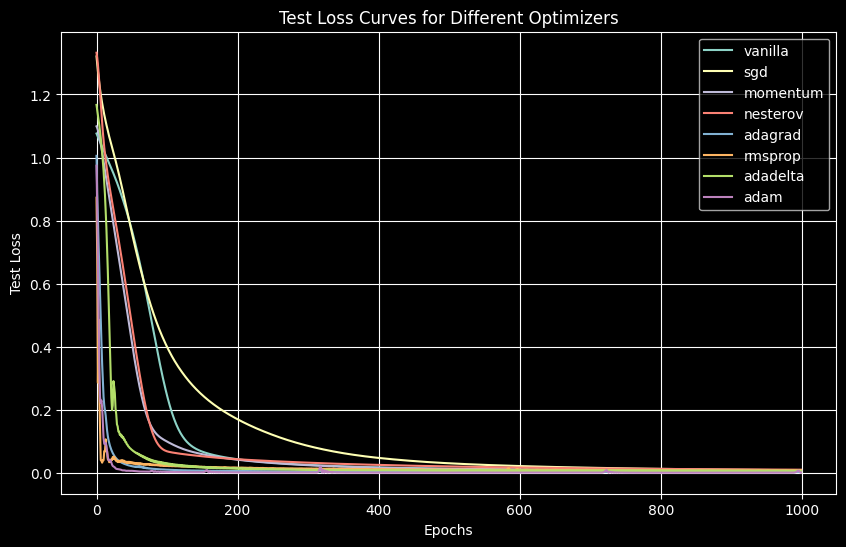

In [28]:
# Plot test loss curves
plt.figure(figsize=(10, 6))
for method, losses in test_loss_curves.items():
    plt.plot(losses, label=method)

plt.title("Test Loss Curves for Different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.legend()
plt.grid()
plt.show()